# DS/ML Training Camp: Matrix Factorization with Distributed SGD
----
<span style="color:red">INTERNAL USE ONLY, DO NOT SHARE</span>

## Introduction

In this assignment, we will work on a recommendation problem based on the real world dataset from both Yelp and Amazon Review Datasets. The ultimate goal of this project is to build the popular matrix factorization based recommendation model and optionally on Spark.

During this assignment, you will need to implement the algorithm from scratch to achive this goal by yourself. But don't worry, this notebook will guide you through those process step by step. To be specific, the tasks in this assignment include:
- Data Pre-processing and Exploratory Data Analysis (EDA)
- Matrix Factorization Algorithm Implementation
- Distributed Stochastic Gradient Descent


Hopefully, after this assignment you can
- Get the idea of how the matrix factorization algorithm works
- Understand how to train the matrix factorization model through SGD
- Get familiar with the basic idea of Spark and how it can help facilitate matrix factorization model learning
- Have hands-on experiences for implementing recommendation algorithm and optionally on Spark

## Dataset

For this project, we will use 2 big datasets, one from Yelp Reviews and another from Amazon Product Reviews. Each of these two datasets consists of a few sub-datasets, for example, Yelp datasets have reviews from 6 different states and Amazon datasets have reviews from 18 different product categories. These sub-datasets are
organized into different folders, and the data is stored in a `.csv` file called `matrix.csv`. To help you focus more on the model/algorithm side, we have pre-processed the raw data for you.

#### Data Format
All the `matrix.csv` files have exactly the same format, there will be 3 columns in the `.csv` file, first column is user_id, second column is item_id and 3rd one is user rating. For the user rating column, both datasets have rating among 1, 2, 3, 4 and 5 (maps to 1-5 stars).


#### Dataset Statistics
Below you can find the dataset statistics, you may want to try your implementation on some smaller datasets first. Given that the rating behaviors can vary over different geo regions or product categories, we use these many sub-datasets to make sure any performance change on your algorithm can be statistical significantly presented.

|Sub-dataset Name (Yelp Reviews)|Number of Reviews|
|---|---|
|Illinois (IL)| 12K  |
|Wisconsin (WI)   | 43K  |
|Pennsylvania (PA)| 66K  |
|North Carolina (NC)|95K|
|Arizona (AZ)|586K|
|Nevada (NV)|674K|

|Sub-dataset Name (Amazon Reviews)|Number of Reviews|
|---|---|
|Musical Instruments| 500K  |
|Instant Video   | 583K  |
|Digital Music| 836K  |
|Baby|915K|
|Patio, Lawn and Garden|993K|
|Pet Supplies|1.23M|
|Office Products|1.24M|
|Grocery & Groumet Food|1.29M|
|Video Games|1.32M|
|Automotives|1.37M|
|Tools & Home Improvements|1.92M|
|Beauty|2.02M|
|Toys & Games|2.25M|
|Apps for Android|2.63M|
|Health & Personal Care|2.98M|
|Kindle Stores|3.20M|
|Sports & Outdoors|3.26M|
|Cell Phones & Accessories|3.44M|
|CDs & Vinyl|3.74M|
|Home & Kitchen|4.25M|
|Movies & TV|4.60M|
|Clothing, Shoes & Jewelry|5.74M|
|Electronics|7.82M|


Note, if possible you can apply your algorithm to all the sub-datasets, but this is not required.

#### Now, open the each file and have a look, then move to the next section

### Environment Setup

Please use Python3.6+ for this assignment, and you should have following Python library installed:
- numpy
- matplotlib

In [1]:
# let's first import some useful Python library first
import sys
import re
import json
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# let's set the path for each file, they should be placed in the same folder as this notebook
yelp_states = ['IL', 'WI', 'PA', 'NC', 'AZ', 'NV']

amazon_products = ['Amazon_Instant_Video', 'Apps_for_Android', 'Automotive', 'Baby', 'Beauty',
                   'Cell_Phones_and_Accessories', 'Digital_Music', 'Grocery_and_Gourmet_Food', 
                   'Health_and_Personal_Care', 'Kindle_Store', 'Musical_Instruments',
                   'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies', 'Sports_and_Outdoors',
                   'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games']

yelp_datasets = [f'./yelp_datasets/{s}/matrix.csv' for s in yelp_states]
amazon_datasets = [f'./amazon_datasets/{s}/matrix.csv' for s in amazon_products]

In [3]:
for path in yelp_datasets + amazon_datasets:
    print(path)

./yelp_datasets/IL/matrix.csv
./yelp_datasets/WI/matrix.csv
./yelp_datasets/PA/matrix.csv
./yelp_datasets/NC/matrix.csv
./yelp_datasets/AZ/matrix.csv
./yelp_datasets/NV/matrix.csv
./amazon_datasets/Amazon_Instant_Video/matrix.csv
./amazon_datasets/Apps_for_Android/matrix.csv
./amazon_datasets/Automotive/matrix.csv
./amazon_datasets/Baby/matrix.csv
./amazon_datasets/Beauty/matrix.csv
./amazon_datasets/Cell_Phones_and_Accessories/matrix.csv
./amazon_datasets/Digital_Music/matrix.csv
./amazon_datasets/Grocery_and_Gourmet_Food/matrix.csv
./amazon_datasets/Health_and_Personal_Care/matrix.csv
./amazon_datasets/Kindle_Store/matrix.csv
./amazon_datasets/Musical_Instruments/matrix.csv
./amazon_datasets/Office_Products/matrix.csv
./amazon_datasets/Patio_Lawn_and_Garden/matrix.csv
./amazon_datasets/Pet_Supplies/matrix.csv
./amazon_datasets/Sports_and_Outdoors/matrix.csv
./amazon_datasets/Tools_and_Home_Improvement/matrix.csv
./amazon_datasets/Toys_and_Games/matrix.csv
./amazon_datasets/Video_Game

## Data Pre-processing and Exploratory Data Analysis (EDA)

Before we start dive into the recommendation algorithm, it's worth taking a look at the rating distribution for each dataset. Different rating distribution may indicate different difficulty level and different expected results.

Also, we have already re-indexed the user_id and item_id for you, so they all now start from 0 and end at MAX_ID, the total number of unique IDs should be MAX_ID+1.

In [4]:
def preprocess(data_file: str) -> Tuple:
    reviews = []    
    
    # For verification purpose
    user_id_set = set()
    item_id_set = set()
    max_user_id = 0
    max_item_id = 0
    
    with open(data_file) as f:
        for line in f:
            if not line:
                continue
            user_id, item_id, rating = line.strip().split(',')
            user_id, item_id, rating = int(user_id), int(item_id), float(rating)
            
            max_user_id = max(max_user_id, user_id)
            max_item_id = max(max_item_id, item_id)
            user_id_set.add(user_id)
            item_id_set.add(item_id)
            reviews.append((user_id, item_id, rating))
    
    # Verify the indexing, DO NOT CHANGE
    assert len(user_id_set) == max_user_id+1, \
        f"User IDs are not properly re-indexed, {len(user_id_set)} vs {max_user_id+1}"
    assert len(item_id_set) == max_item_id+1, \
        f"Item IDs are not properly re-indexed, {len(item_id_set)} vs {max_item_id+1}"
    
    
    return reviews, max_user_id+1, max_item_id+1

Now let's load one dataset

In [5]:
# (Optional) Feel free to change the dataset here
dataset_file = './yelp_datasets/IL/matrix.csv'

In [6]:
reviews, user_dim, item_dim = preprocess(dataset_file)
print(f'Number of reviews: {len(reviews)}')
print(f'User dimension: {user_dim}')
print(f'Item dimension: {item_dim}')

Number of reviews: 12030
User dimension: 3894
Item dimension: 627


In [7]:
# Remember the `reviews` variable has the format [(user_id, item_id, rating), ...]
star_list = [int(x[2]) for x in reviews]
print(star_list[:10])

[3, 3, 4, 4, 4, 5, 5, 5, 1, 5]


Next, let's use following functions to visualize the distribution of ratings from different datasets, i.e., the number of review instances with 1 star, 2 stars, 3 stars, 4 stars and 5 stars respectively.

In [8]:
def get_label_counts(star_list: List[int]) -> List[int]:
    stars_count = [0] * 5 # 1-5 stars
    for star in star_list:
        stars_count[star-1] += 1
    print('star counts:', stars_count)
    print('distribution:', np.array(stars_count, dtype=float) / sum(stars_count))
    return stars_count

def plot_bar_chart(labels, values, title, ylabel):
    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

star counts: [1141, 1224, 1889, 3599, 4177]
distribution: [0.09484622 0.10174564 0.15702411 0.29916874 0.3472153 ]


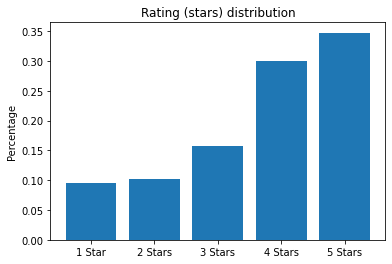

In [9]:
stars_count = get_label_counts(star_list)
plot_bar_chart(
    labels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
    values=np.array(stars_count, dtype=float) / sum(stars_count),
    title='Rating (stars) distribution',
    ylabel='Percentage'
)

In [10]:
# TODO: Implement this function to visualize the star distribution
#       for all the datasets
def visualize_rating_distribution(datasets):
    for dataset in datasets:
        print(dataset)
        # preprocess
        reviews, user_dim, item_dim = preprocess(dataset)
        # star list
        star_list = [int(x[2]) for x in reviews]
        stars_count = get_label_counts(star_list)
        
        plot_bar_chart(
            labels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
            values=np.array(stars_count, dtype=float) / sum(stars_count),
            title='Rating (stars) distribution',
            ylabel='Percentage'
        )

./yelp_datasets/IL/matrix.csv
star counts: [1141, 1224, 1889, 3599, 4177]
distribution: [0.09484622 0.10174564 0.15702411 0.29916874 0.3472153 ]


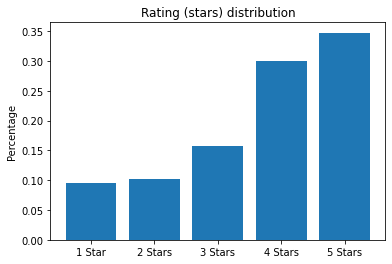

./yelp_datasets/WI/matrix.csv
star counts: [3483, 4287, 6564, 14115, 14889]
distribution: [0.08036827 0.09892012 0.15146061 0.32569569 0.34355531]


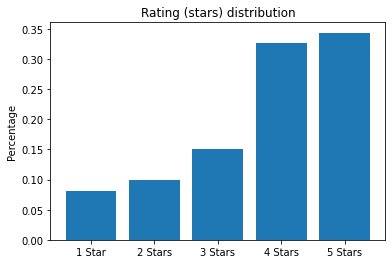

./yelp_datasets/PA/matrix.csv
star counts: [4943, 6301, 10475, 21302, 22582]
distribution: [0.07534716 0.09604744 0.15967258 0.32471076 0.34422206]


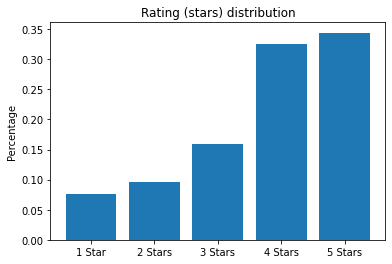

./yelp_datasets/NC/matrix.csv
star counts: [8066, 8779, 15873, 32633, 29674]
distribution: [0.08488293 0.09238621 0.16704025 0.34341489 0.31227572]


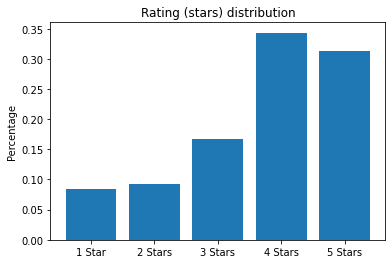

./yelp_datasets/AZ/matrix.csv
star counts: [64123, 51104, 73094, 166308, 231676]
distribution: [0.10936799 0.08716282 0.1246689  0.28365441 0.39514587]


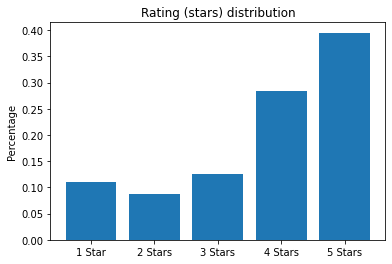

./yelp_datasets/NV/matrix.csv
star counts: [72031, 61988, 99521, 195233, 246197]
distribution: [0.10671734 0.09183816 0.14744507 0.28924693 0.36475251]


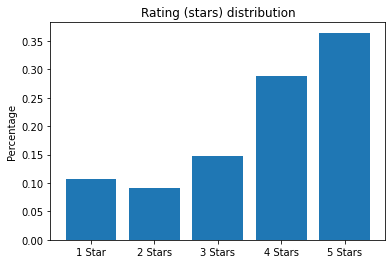

./amazon_datasets/Amazon_Instant_Video/matrix.csv
star counts: [36308, 23262, 40683, 98406, 377598]
distribution: [0.06300661 0.04036741 0.07059871 0.17076756 0.65525972]


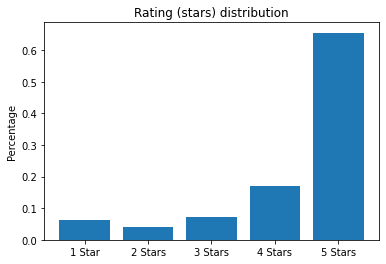

./amazon_datasets/Apps_for_Android/matrix.csv
star counts: [291985, 133001, 252124, 559134, 1386946]
distribution: [0.11130913 0.05070201 0.09611351 0.2131504  0.52872495]


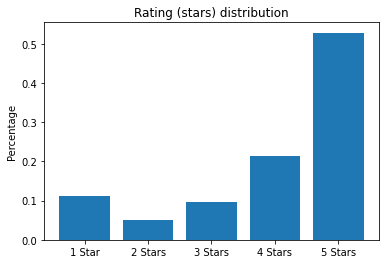

./amazon_datasets/Automotive/matrix.csv
star counts: [121446, 63810, 103217, 228596, 844173]
distribution: [0.08921705 0.04687631 0.07582561 0.16793193 0.6201491 ]


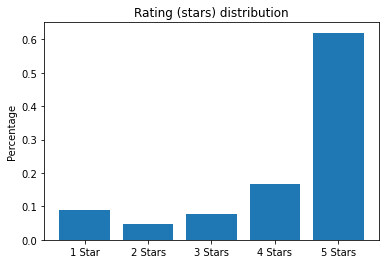

./amazon_datasets/Baby/matrix.csv
star counts: [76697, 56198, 82738, 164628, 531385]
distribution: [0.08413024 0.06164454 0.09075672 0.18058325 0.58288524]


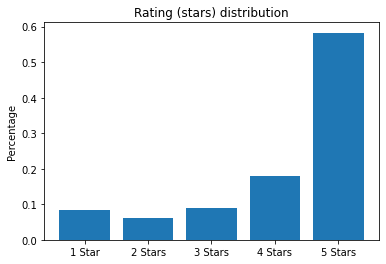

./amazon_datasets/Beauty/matrix.csv
star counts: [182590, 112426, 168788, 305897, 1237815]
distribution: [0.0909532  0.05600254 0.08407803 0.15237587 0.61659035]


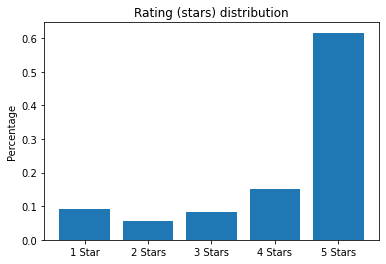

./amazon_datasets/Cell_Phones_and_Accessories/matrix.csv
star counts: [494556, 254795, 349155, 627276, 1685991]
distribution: [0.14495572 0.07468111 0.10233829 0.18385631 0.49416857]


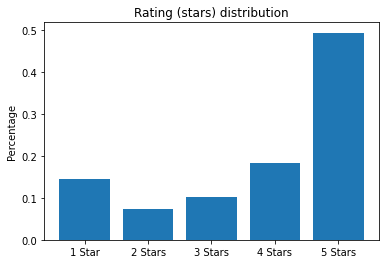

./amazon_datasets/Digital_Music/matrix.csv
star counts: [29824, 19668, 41100, 121731, 617032]
distribution: [0.03596048 0.02371481 0.04955658 0.14677792 0.74399021]


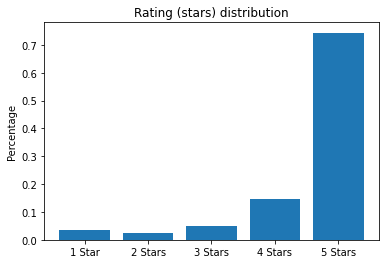

./amazon_datasets/Grocery_and_Gourmet_Food/matrix.csv
star counts: [101722, 62078, 96345, 176753, 851832]
distribution: [0.07893197 0.0481699  0.07475965 0.13715286 0.66098562]


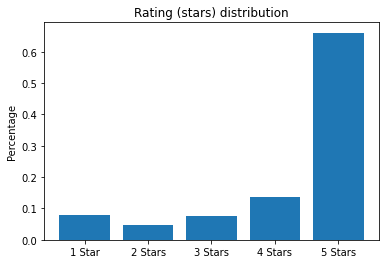

./amazon_datasets/Health_and_Personal_Care/matrix.csv
star counts: [293086, 167863, 240216, 486439, 1772256]
distribution: [0.09902022 0.05671316 0.08115789 0.16434527 0.59876346]


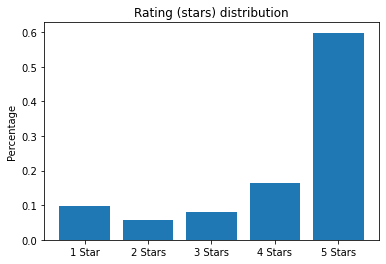

./amazon_datasets/Kindle_Store/matrix.csv
star counts: [172033, 142569, 305494, 723058, 1848771]
distribution: [0.05389632 0.04466552 0.09570839 0.22652725 0.57920252]


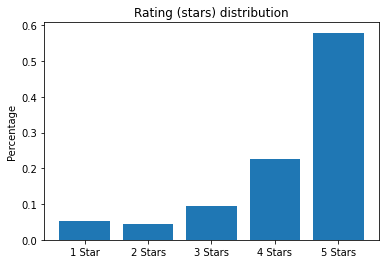

./amazon_datasets/Musical_Instruments/matrix.csv
star counts: [34779, 22558, 38397, 92921, 308680]
distribution: [0.06993073 0.04535776 0.07720551 0.18683785 0.62066816]


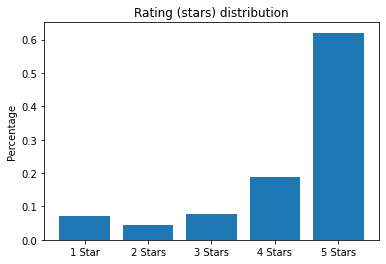

./amazon_datasets/Office_Products/matrix.csv
star counts: [157075, 72657, 98731, 221057, 686083]
distribution: [0.12712417 0.05880287 0.07990512 0.17890617 0.55526168]


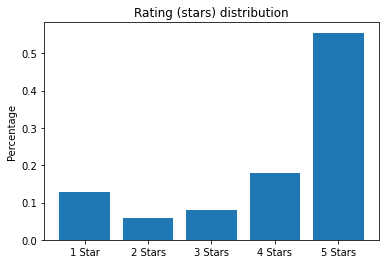

./amazon_datasets/Patio_Lawn_and_Garden/matrix.csv
star counts: [118887, 57174, 80434, 173086, 554880]
distribution: [0.12076354 0.05807645 0.08170359 0.17581804 0.56363838]


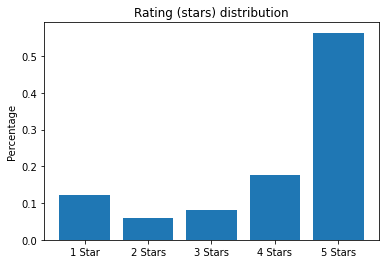

./amazon_datasets/Pet_Supplies/matrix.csv
star counts: [117284, 74099, 104498, 193867, 739055]
distribution: [0.09544573 0.06030177 0.08504048 0.15776898 0.60144303]


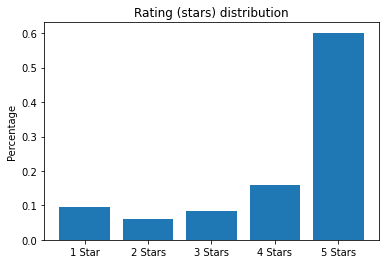

./amazon_datasets/Sports_and_Outdoors/matrix.csv
star counts: [246820, 168327, 276829, 638301, 1915651]
distribution: [0.07603989 0.0518579  0.08528501 0.19664669 0.59017052]


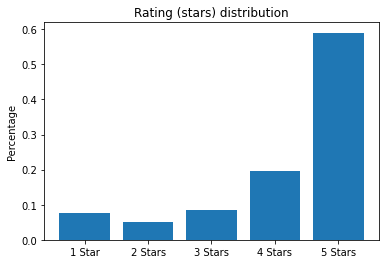

./amazon_datasets/Tools_and_Home_Improvement/matrix.csv
star counts: [180085, 99206, 152413, 344972, 1136310]
distribution: [0.09413817 0.05185924 0.07967283 0.18033169 0.59399807]


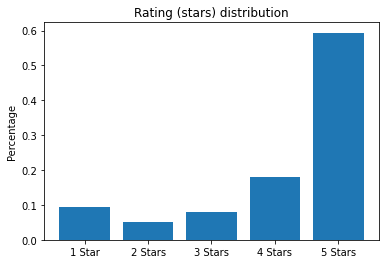

./amazon_datasets/Toys_and_Games/matrix.csv
star counts: [192308, 115420, 193220, 406176, 1331740]
distribution: [0.08589535 0.05155293 0.0863027  0.18142058 0.59482845]


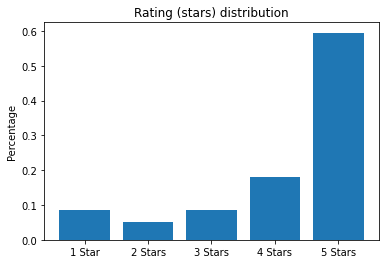

./amazon_datasets/Video_Games/matrix.csv
star counts: [152343, 77355, 124022, 259411, 705091]
distribution: [0.11556703 0.05868131 0.09408279 0.19678855 0.53488032]


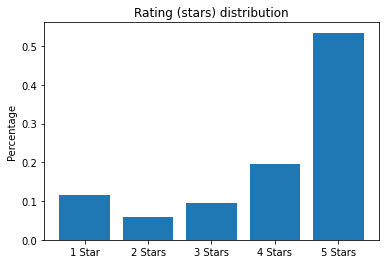

In [11]:
visualize_rating_distribution(yelp_datasets + amazon_datasets)

Does the distribution look same to you? Which dataset should be easier for model to learn?

Please feel free to try more things to help you understand the datasets, and we encourage you to get familiar with `matplotlib` library, which is very useful in doing visualization in Python. Visualization is a better way to explain what you found in data than words, so you should try to use various types of visualization to present your findings throughout this entire course. To get more visualization ideas, please check out [Matplotlib Gallery](https://matplotlib.org/gallery/index.html), which also includes the source code for implmentation.

## Matrix Factorization

Our goal here is to implement the Matrix Factorization model for recommendation using Stochastic Gradient Descent (SGD). We will start by implementing a standard local version, and then we will extend it to a distributed version introducted from this [paper](https://dl.acm.org/doi/abs/10.1145/2020408.2020426) in Spark.

To recap, in Matrix Factorization, the $m\times n$ user-rating matrix (i.e., each role of the matrix is an user, each column of the metrix is an item, and the cell value is the rating given to the item of that column from the user of that role) is decomposed into two smaller matrix, one is the $m\times k$ user matrix where each row represents a user's hidden vector, another is $k\times n$ item matrix where each column represents an item's hidden vector.

### Problem Definition

In Matrix Factorization, the optimization goal is 

$$
\min_{{W}\in \Bbb R^{m\times k},\ {H}\in \Bbb R^{k\times n} } \sum_{(i,j)\in Z} \big(v_{i,j}-{w}_i^T {h}_j \big)^2 + \lambda(\|{W}\|^2 +\|{H}\|^2)
$$

If we include bias terms, the final loss function for our problem is defined as 

$$
L= \sum_{(i,j)\in Z} \big(v_{i,j}-{w}_i^T {h}_j- b^{(w)}_i - b^{(h)}_j -\mu \big)^2 + \lambda(\sum_i \|{w_i}\|^2 +\sum_j \|{h_j}\|^2 + \|b^{(w)}\|^2 + \|b^{(h)}\|^2)
$$

where $Z$ is the user rating set, $W$ is the user matrix and $H$ is the item matrix, $b^{(w)}$ is the user bias, $b^{(h)}$ is the item bias, $\mu$ is the constant gloabl bias (Note the notation here is different with course material as we want to keep consistent with that paper in case you read it).

### Stochastic Gradient Descent for Matrix Factorization (SGD-MF)

In SGD-MF, we select a single datapoint and update the corresponding row of W and column
of H in the direction of negative gradient.

The gradients for the loss are given as follows:

$$
\frac{\partial L}{\partial w_i} = -2\big(v_{i,j}-{w}_i^T {h}_j- b^{(w)}_i - b^{(h)}_j -\mu \big){h}_j+2\lambda w_i
$$

$$
\frac{\partial L}{\partial h_j} = -2\big(v_{i,j}-{w}_i^T {h}_j- b^{(w)}_i - b^{(h)}_j -\mu \big){w}_i+2\lambda h_j
$$

$$
\frac{\partial L}{\partial b_i^{(w)}} = -2\big(v_{i,j}-{w}_i^T {h}_j- b^{(w)}_i - b^{(h)}_j -\mu \big)+2\lambda b_i^{(w)}
$$

$$
\frac{\partial L}{\partial b_j^{(h)}} = -2\big(v_{i,j}-{w}_i^T {h}_j- b^{(w)}_i - b^{(h)}_j -\mu \big)+2\lambda b_j^{(h)}
$$

The SGD will update the matrix values iteratively using following rule:

$$
w_i = w_i - \alpha\frac{\partial L}{\partial w_i}
$$

$$h_j = h_j - \alpha\frac{\partial L}{\partial h_j}$$

$$b_i^{(w)} = b_i^{(w)} - \alpha\frac{\partial L}{\partial b_i^{(w)}}$$

$$b_j^{(h)} = b_j^{(h)} - \alpha\frac{\partial L}{\partial b_j^{(h)}}$$

where $\alpha$ is the learning rate (how fast it converges) and $\lambda$ is the regularization parameter (biases against extreme models).

Make sure you can derive them by yourself, then you can start to implement.

In [93]:
# TODO: Let's first initialize our model parameter randomly.
#       You need to fill the correct dimensions for each parameters
def get_initial_model_parameters(user_dim: int, item_dim: int, k: int) -> Tuple:
    
    W = np.random.rand(user_dim, k)
    H = np.random.rand(k, item_dim)
    user_bias = np.random.rand(user_dim)
    item_bias = np.random.rand(item_dim)
    
    return W, H, user_bias, item_bias

In [94]:
# TODO: implement this function to calculate global bias as mean rating from dataset
def get_global_bias(reviews: List[Tuple]) -> float:
    return np.mean([float(x[2]) for x in reviews])

If you test your function with Yelp IL dataset, you should get something around 3.7

In [95]:
print(get_global_bias(reviews))

3.702161263507897


In [96]:
# TODO: implement this function to make prediction on one single instance,
#       the output should be a real number
def predict(
    W: np.ndarray,
    H: np.ndarray,
    user_bias: np.ndarray,
    item_bias: np.ndarray,
    global_bias: np.ndarray,
    user_idx: int,
    item_idx: int
) -> np.ndarray:
    predicted_rating = np.dot(W[user_idx], H.T[item_idx])+user_bias[user_idx] + item_bias[item_idx]+ global_bias
    
    return predicted_rating

Let's make sure all your functions can work

In [97]:
W, H, user_bias, item_bias = get_initial_model_parameters(user_dim=user_dim, item_dim=item_dim, k=5)

In [98]:
mu = get_global_bias(reviews)

In [99]:
predict(W, H, user_bias, item_bias, mu, 0, 0)

5.7698304681298875

### Evaluation

This an iterative algorithm, to help make sure your implementation is correct, we need to implement the evaluation function to verify the training process is moving towards the direction we want.

Since we are predicting the user rating, we can use MSE as the evaluation metrics:

$$\text{MSE}=\frac{1}{n}\sum_{i=1}^n(\hat{r}_i-r_i)^2$$

where $\hat{r}_i$ is your predicted rating for i-th instance, $r_i$ is the corresponding true rating and $n$ is the total number of rating instances in the dataset used for evaluation. 

Now let's implement the following function to caculate the MSE for the given dataset. 

In [66]:
# TODO: implement the evaluate function to return the MSE
# user_id, item_id, rating
def evaluate(reviews, W, H ,user_bias, item_bias, mu) -> float:
    se = 0 
    global_bias = get_global_bias(reviews)
    for review in reviews:
        user_idx = review[0]
        item_idx = review[1]
        predicted_rating = np.dot(W[user_idx], H[item_idx])+user_bias[user_idx] + item_bias[item_idx]+ global_bias
        se += (review[2]- predicted_rating) ** 2
        
    mse = se/len(reviews)
    
    
    return mse

### Dataset Split

Since you only have a whole dataset with user ratings, to better evaluate the algorithm results, you should split your dataset into training and validation. The simplest way to do this is setting a split ratio, say 0.8 (e.g., 80% training and 20% validation), then use a random number generator to generate random numbers between zero and one for each sample, if the random number is smaller than your split ratio (i.e., 0.8), you put this sample in training data, otherwise put it in validation data.

PS: You can also try to implement K-Fold cross validation and use it for evaluation during the training, which should get you more accurate results.

In [67]:
# TODO: implement this function using the logic mentioned above
def prob_dataset_spliter(dataset, split_ratio=0.8):
    train = []
    val = []
    for data in dataset:
        random_num = np.random.rand()
        if random_num < split_ratio:
            train.append(data)
        else:
            val.append(data)

    return train, val

Let's test it, while if the number does not exactly match, do you have any idea?

In [68]:
# Let's test it
np.random.seed(999)
test_data = list(range(1000))
split_ratio = 0.6
train, val = prob_dataset_spliter(test_data, split_ratio)
real_ratio = len(train) / len(test_data)
assert abs(real_ratio - split_ratio) < 0.01, "Please double check your function"

### Matrix Factorization Algorithm


Great!! Now let's put everything together and implement the training function for Matrix Factorization. During the training process, you will implement the stochastic gradient descent, use the helper functions you have implemented in the previous section to help complete the training function.


To help start, the pseudocode of the algorithm can be described as:

Require: Training indices $Z$, Training data $V$, randomly initialized $W$, $H$, user bias, item bias and pre-compute global bias

```
while not converged do:
    Select a training point (i, j) ∈ Z uniformly at random
    Compute gradients of each variable
    Update the gradient of corresponding row in W, column in H and biases
end while
```

Some additional thoughts:
- To help make sure the trainig in on the right direction, you should check the MSE value on both training and validation datasets regularly during the training (e.g., after certain number of iterations)
- Think about what other stopping criteria you should use for the training (the default one is fixed 100 iterations)
- You may want to shuffle the order of training samples each time you used the entire dataset
- After you figure out the training process, you can tune the hyper-parameters based on your understanding about how the training works (we have already used a dynamic learning rate here)

In [69]:
import random

In [70]:
# TODO: implement this function to train the MF model with SGD. Note the lambda_v 
#       is the regularizatioon parameter, beta_v is used for dynamic learning rate,
#       and seed is used for reproducibility
def train_mf_with_sgd(dataset_file: str, hidden_dim=5, num_iter=100, lambda_v=1.0, beta_v=0.5, seed=0):
    # Preprocess the dataset file
    reviews, user_dim, item_dim = preprocess(dataset_file)
    
    # Initialize the model parameters
    np.random.seed(seed)
    
    W, H, user_bias, item_bias = get_initial_model_parameters(user_dim, item_dim, hidden_dim) 
    
    # Split the dataset
    np.random.seed(seed)
    split_ratio = 0.8
    training_set, val_set = prob_dataset_spliter(reviews, split_ratio)
    
    # Get the gloabl bias using training dataset]
    
    mu = get_global_bias(training_set)
    
    print('Start iterations...')
    T = 0
    cnt = 0.0
    
    # Evaluate the initial MSE with random numbers
    MSE_train = evaluate(training_set, W, H, user_bias, item_bias, mu)
    MSE_val = evaluate(val_set, W, H, user_bias, item_bias, mu)
    print(f'Iter:{T} training_set MSE={MSE_train}, val_set MSE={MSE_val}')
    
    while T < num_iter:
        for idx, (i, j, v) in enumerate(training_set):
            # Using adaptive learning rate
            alpha = (100 + idx + cnt) ** (-beta_v)

            # Calculate and update the gradients here
            # np.dot(W[user_idx], H.T[item_idx])+user_bias[user_idx] + item_bias[item_idx]+ global_bias
            grad_w = -2 *(v - np.dot(W[i], H[j]) - user_bias[i] - item_bias[j] - mu) * H[j] + 2*lambda_v * W[i] 
            grad_h = -2 *(v - np.dot(W[i], H[j]) - user_bias[i] - item_bias[j] - mu) * W[i] + 2*lambda_v * H[j] 
            grad_u = -2 *(v - np.dot(W[i], H[j]) - user_bias[i] - item_bias[j] - mu) + 2*lambda_v * user_bias[i]
            grad_i = -2 *(v - np.dot(W[i], H[j]) - user_bias[i] - item_bias[j] - mu) + 2*lambda_v * item_bias[j]

            W[i] = W[i] - alpha * grad_w
            H[j] = H[j] - alpha * grad_h
            user_bias[i] = user_bias[i] - alpha * grad_u
            item_bias[j] = item_bias[j] - alpha * grad_i

        T += 1
        cnt += len(training_set) # ?
        # Shuffle the dataset
        random.shuffle(training_set)


        MSE_train = evaluate(training_set, W, H, user_bias, item_bias, mu)
        MSE_val = evaluate(val_set, W, H, user_bias, item_bias, mu)
        print(f'Iter:{T} training_set MSE={MSE_train}, val_set MSE={MSE_val}')
    return W, H, user_bias, item_bias, mu

Let's apply your algorithm to a real dataset and see how it goes! It's recommended to develop on a smaller dataset for debugging purpose, once you are confident the implementation is correct, you can start to test on bigger dataset.

In [71]:
W, H, user_bias, item_bias, mu = train_mf_with_sgd(dataset_file)

Start iterations...


IndexError: index 257 is out of bounds for axis 0 with size 5

Did you see the RMSE going down for both traininbg and validation set? If so, great job! Also keeps an eye on common issues during the training like underfitting or overfitting. You can use the table in Appendix to compare your results.

### Recommendation

Now you have got the matrix factorization model, you can use it to predict the rating for any item from any user, just use the `predict` function you have built before.

In [32]:
# 4.79092334086274
predict(W, H, user_bias, item_bias, mu, 7, 2)

4.79092334086274

<span style="color:blue">Once you are good with your own implementation, you can move to the next part!</span>

## Distributed Stochastic Gradient Descent in Spark (optional)

In this optional section, we will implement the SGD based Matrix Factorization algorithm in Spark.

### Brief Introduction to Spark

Spark is a data science software that allows you to write your data processing code in Scala, Python, or Java. We have a brief intro to Spark in video lecture at last week, here we summrize some key features of Spark related to this project:

- The data is loaded as a Resilient Distributed Database (RDD) from either the local filesystem or HDFS.
- RDDs can be converted into other RDDs using transformations such as map, filter, reduceByKey, etc.
- The evaluation of RDDs is lazy i.e. the required result won’t be evaluated until you explicitly invoke an action indicating that you need the result.

This allows Spark to optimize the execution of transformations scheduled on RDDs.

Another useful feature of Spark is in-memory processing. You can specify that you want to cache an RDD in memory if you intend to reuse the RDD through multiple iterations of your data processing job. The full set of transformations that convert one RDD into another, and actions which force the calculation of a result can be found in the [Spark programming guide](http://spark.apache.org/docs/2.4.6/quick-start.html). The programming guide is also a good introduction to Spark. A more detailed RDD API reference with examples can be found [here](http://spark.apache.org/docs/2.4.6/api/python/pyspark.html#pyspark.RDD). If you prefer a lecture, there are many you can find on Youtube.

### Set Up Local Development Environment for Spark

The final goal is to make sure you can run `spark-submit` in your terminal, you can use following docs as reference. Feel free to search online and find other tutorial if this one doesn't work for you.

Example Tutorial: [How to install PySpark locally](https://medium.com/tinghaochen/how-to-install-pyspark-locally-94501eefe421)

Additional comments to the tutorial:
- Install Python3 (skip if you have already had), you don't need to install Anaconda, you can use brew if you are using macOS or download Python3 from official website
- Download [Spark](https://spark.apache.org/downloads.html) with version `2.4.6` (don't use 3.x as it's a bit too new) with package type `prebuilt for Apache Hadoop 2.7` (you won't need Hadoop for this project, so don't worry)
- Install `pyspark` with Python 3 (e.g., `pip3 install pyspark`)
- Export all 3 following environment variables at the end of your *sh config
```
export PYSPARK_PYTHON=python3
export SPARK_HOME="/path/to/this/folder/spark-2.4.6-bin-hadoop2.7"
export PATH="$SPARK_HOME/bin:$PATH"
```
- You can go to the SPARK_HOME and run the test Spark job for calculating Pi (i.e., run `./bin/run-example SparkPi 10` when you are in the `spark-2.4.6-bin-hadoop2.7` folder)

### Key Ideas

When we apply stochastic gradient descent to the user rating matrix, a pair of elements given as $(i,j)$ and $(i',j')$ is interchangeable if $i\neq i'$  and $j\neq j'$. See the third chart below for an example. If two such elements are interchangeable, then the stochastic gradient descent updates involving $\{v_{ij},w_i,h_j\}$ and $\{v_{i'j'},w_{i'},h_{j'}\}$ do not depend on each other in any way and can be performed in parallel.

A set of elements of a matrix is interchangeable if any pair of elements in the set is interchangeable. The stochastic gradient descent updates involving the local losses of a set of interchangeable elements are also parallel due to the fact that they depend on disjoint parts of the data matrix $V$ and the factor matrices $W$ and $H$.

We can generalize the notion of interchangeability from elements of a matrix to blocks of the matrix. Consider $I$ and $I′$ are sets of row indices of $V$. Similarly, $J$ and $J′$ are sets of column indices of $V$. Matrix blocks $IJ$ and $I′J′$ are interchangeable if $I ∩ I′ = \phi$ and $J ∩ J′ = \phi$, where $IJ$ denotes the cartesian product of sets $I$ and $J$, and $V_{IJ}$ denotes a matrix block with some abuse and inelegance of notation. Similar to the case of element exchangeability, the stochastic gradient descent updates involving $\{V_{IJ} , W_{I∗}, H_{∗J} \}$ and $\{V_{I′J′} , W_{I′∗}, H_{∗J′}\}$ do not depend on each other in any way and can be performed in parallel.

As in the case of element interchangeability, block interchangeability generalizes from a pair of matrix blocks to a set of matrix blocks. A set of matrix blocks is said to be interchangeable if any pair of those matrix blocks is interchangeable. Stochastic gradient descent updates involving interchangeable matrix blocks can be parallelized since they depend on disjoint parts of the data matrix $V$ and the factor matrices $W$ and $H$.

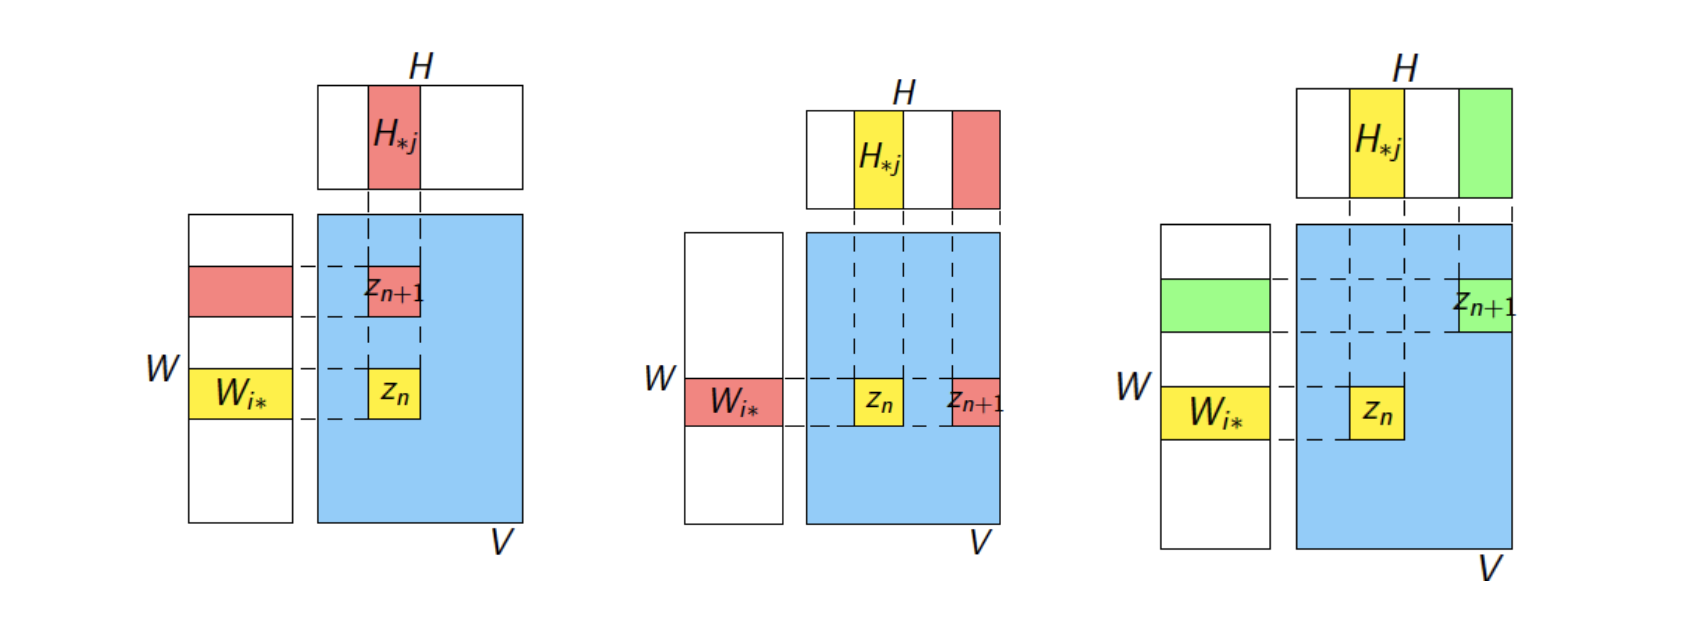

Given a matrix block VIJ and the coupled parameter blocks $W_{I∗}$ and $H_{∗J}$ , we can perform sequential stochastic gradient descent for this disjoint part of the matrix and its parameters without having to worry about any parallel updates that might affect  $W_{I∗}$ and $H_{∗J}$. Thus, we have established a concurrent model for stochstic gradient descent updates for matrix factorization. Interchangeable matrix blocks are also called strata, and hence this concurrent algorithm of performing SGD is also called Stratified Stochastic Gradient Descent (SSGD).

Having established concurrency in SSGD, here we show how to parallelize SSGD to yield Distributed Stochastic Gradient Descent algorithm for matrix factorization (i.e., DSGD-MF) in the below chart.


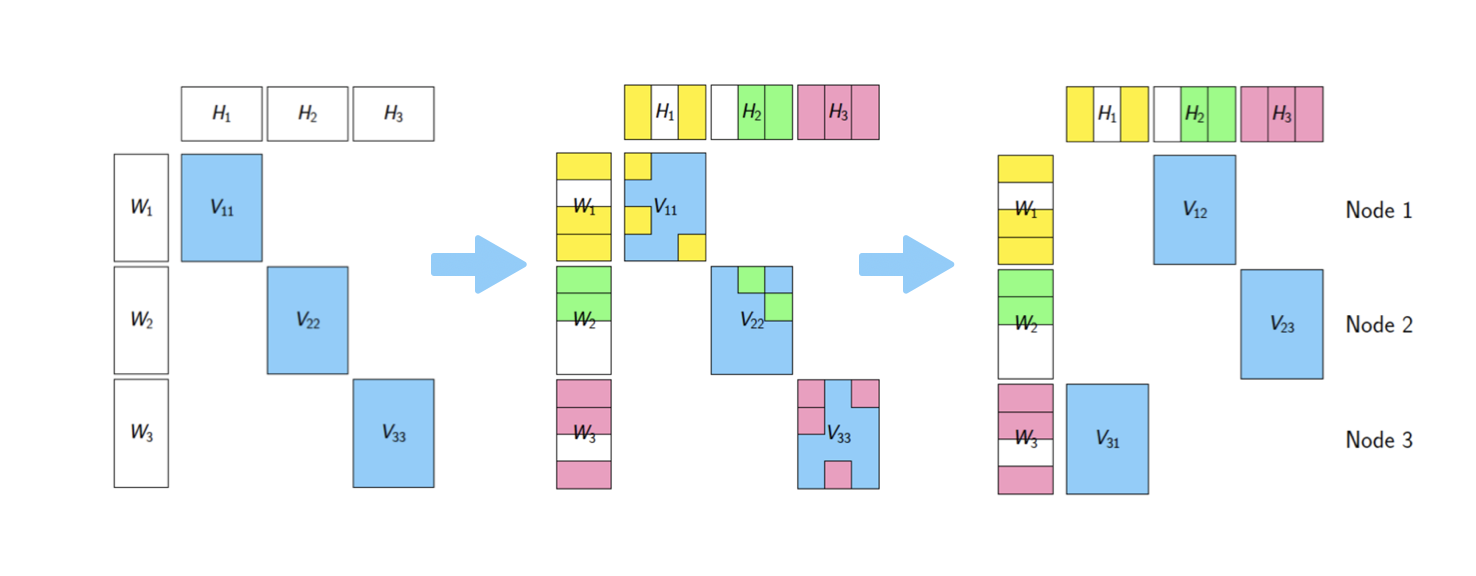

Read through this [paper](https://dl.acm.org/doi/abs/10.1145/2020408.2020426) (included in the project files) to understand the full idea of distributed stochastic gradient descent.

### Implementation

We have provided the basic implementation of DSGD Matrix Factorization in the Python file `mf_dsgd_spark.py` (included in the project files). You can use `spark-submit` to run this file with your local Spark. While the implementation in this file is very basic (e.g., no bias terms, no optimization, no k-fold cross validation etc.), it has demonstrated the key ideas of DSGD well. Your tasks are:
- Read through the code, understand how DSGD is implemented in Spark
- Improve the MF model performace, for instance, by adding bias terms in the code, so the DSGD MF can peform at least as good as your local SGD version.
- Select a bigger dataset, compare the running time of local SGD and DSGD using same number of iterations (make sure the comparison is fair)

## Appendix: Performance Evaluation Reference

To help you understand how good your implementation is, we have conducted experiments on all the datasets we provided. Each dataset is randomly divided into training, validation and test sets. We use 80% of each dataset for training, 10% for validation and remaining 10% for testing. For evaluation, we share the MSE on test set when the model achieves its best result on the validation set. Also, to avoid the bias introduced by dataset partitioning, we run each experiment for many times (typically 50-100) and share the average MSE as well as the corresponding standard deviation (in parentheses).

The number of hidden factor (i.e., K) is set as 5 in all of the experiments. The global bias in matrix factorization is initialized as the average rating of the training set. Other matrix factorization related parameters (i.e., the user and item biases as well as the hidden factors) are initialized with uniform distribution between 0 and 0.01. The hyper-parameters are tuned separately for each dataset by grid search.


|Sub-dataset Name (Yelp Reviews)|MSE (stdev)|
|---|---|
|Illinois (IL)| 1.444 (.041)  |
|Wisconsin (WI)   | 1.332 (.024)  |
|Pennsylvania (PA)| 1.266 (.021)  |
|North Carolina (NC)|1.297 (.017)|
|Arizona (AZ)|1.488 (.008)|
|Nevada (NV)|1.426 (.006)|

|Sub-dataset Name (Amazon Reviews)|MSE (stdev)|
|---|---|
|Musical Instruments| 1.319 (.010)  |
|Instant Video   | 1.110 (.009)  |
|Digital Music| 0.800 (.007)  |
|Baby|1.447 (.006)|
|Patio, Lawn and Garden|1.706 (.008)|
|Pet Supplies|1.565 (.007)|
|Office Products|1.740 (.006)|
|Grocery & Groumet Food|1.428 (.006)|
|Video Games|1.580 (.005)|
|Automotives|1.510 (.007)|
|Tools & Home Improvements|1.524 (.005)|
|Beauty|1.571 (.005)|
|Toys & Games|1.393 (.004)|
|Apps for Android|1.484 (.004)|
|Health & Personal Care|1.588 (.005)|
|Kindle Stores|1.067 (.003)|
|Sports & Outdoors|1.390 (.004)|
|Cell Phones & Accessories|1.913 (.005)|
|CDs & Vinyl|0.946 (.003)|
|Home & Kitchen|1.567 (.004)|
|Movies & TV|1.222 (.002)|
|Clothing, Shoes & Jewelry|1.401 (.003)|
|Electronics|1.673 (.003)|

## Summary

Now you have reached the end of this assignment! Congratulations! In this assignment you have built a popular recommendation model from scratch and understand how we can extend the local algorithm to distributed version. In real world machine learning, we will need to deal with huge amount of data, so most of the models/algorithms are trained in a distributed fashion. If you are interested to know more, free feel to explre the Spark MLlib and see which algorithms are included in the library and how they got implemented through Spark.